In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
df_news = pd.read_csv('news_headlines.csv')
df_news.publish_date = pd.to_datetime(df_news.publish_date, format='%Y%m%d')
df_news['publish_year'] = df_news.publish_date.dt.year
df_news.sort_values('publish_date', inplace=True)
print('Rows: {}'.format(len(df_news)))
df_news.head()

Rows: 1000001


,publish_date,headline_text,publish_year
23668,2003-02-19,surge in new car sales in aust abs,2003
6089,2003-02-19,new zealand imposes visa entry for zimbabwe,2003
8208,2003-02-19,nsw opp defends claims of running race campaign,2003
29533,2003-02-19,qantas war plan to cut 2500 jobs outrages unions,2003
20646,2003-02-19,sterrey to steer sharks,2003


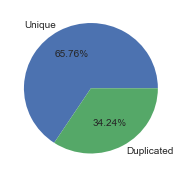

In [34]:
df_news.duplicated().map({True: 'Duplicated', False: 'Unique'}).value_counts().plot(
    kind='pie', autopct='%.2f%%', figsize=(3, 3), label='')

In [35]:
df_news.drop_duplicates(inplace=True)

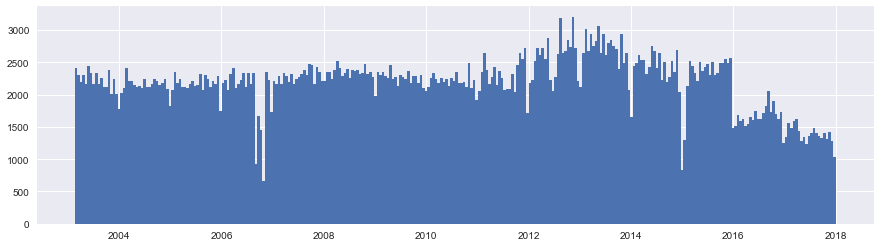

In [47]:
fig, ax = plt.subplots(figsize=(15,4))
df_news.publish_date.hist(ax=ax, bins=300);

# Pre processing text

In [23]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

def pre_processing(text):
    words = word_tokenize(text.lower(), language='english')
    words = [w for w in words if not w in stopwords]  # Remove stop words
    words = [w for w in words if not w in string.punctuation]  # Remove pontuacao
    words = [stemmer.stem(w) for w in words]  # Extrai radical da palavra
    return ' '.join(words)

In [27]:
%%time
df_news['text'] = df_news.headline_text.apply(pre_processing)
df_news.head()

,publish_date,headline_text,text
0,20030303,unhooked brakes to blame for taiwan train disa...,unhook brake to blame for taiwan train disast
1,20030918,oldest prisoner in tas released citing health,oldest prison in tas releas cite health
2,20030913,nine reportedly dead in portuguese plane crash,nine report dead in portugues plane crash
3,20031031,nurses welcome medicare rebate plan,nurs welcom medicar rebat plan
4,20030930,un cuts its iraq staff,un cut it iraq staff


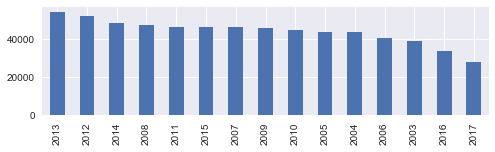

In [44]:
df_news.publish_year.value_counts().plot(kind='bar', figsize=(8, 2))

In [37]:
df_news.to_pickle('df_news.pkl')

# Feature extraction

In [2]:
from sklearn.externals import joblib

df_news = joblib.load('df_news.pkl')

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

X = df_news.text.values

vectorizer = CountVectorizer(max_df=0.8, min_df=0.0001)
counts = vectorizer.fit_transform(X)

tf_transformer = TfidfTransformer()#use_idf=False)
freqs = tf_transformer.fit_transform(counts)

freqs.shape

(657586, 5610)

In [23]:
import os
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

use_cache = True

inertias, scores, metrics = {}, {}, {}
n_clusters = range(2, 51, 2)
years = df_news.publish_year.unique()
for year in tqdm_notebook(years):
    X_ = df_news[df_news.publish_year == year].text.values
    counts_ = vectorizer.transform(X_)
    freqs_ = tf_transformer.transform(counts_)
    print(year, freqs_.shape)
    inertias[year], scores[year], metrics[year] = [], [], []
    for n_cluster in tqdm_notebook(n_clusters):
        cluster_path = os.path.join('KMeans', 'KMeans_{}_{}.pkl'.format(year, n_cluster))
        if not use_cache or not os.path.exists(cluster_path):
            cluster = KMeans(n_cluster, random_state=1986, n_jobs=-1)
            cluster.fit(freqs_)
            joblib.dump(cluster, cluster_path)
        else:
            cluster = joblib.load(cluster_path)
        inertias[year].append(cluster.inertia_)
        scores[year].append(cluster.score(freqs_))  
        metrics[year].append(silhouette_score(freqs_, cluster.labels_, random_state=1986, sample_size=5000))


2003 (38643, 5610)


2004 (43470, 5610)


2005 (43600, 5610)


2006 (40234, 5610)


2007 (45991, 5610)


2008 (47307, 5610)


2009 (45538, 5610)


2010 (44617, 5610)


2011 (46133, 5610)


2012 (52075, 5610)


2013 (54055, 5610)


2014 (48436, 5610)


2015 (46060, 5610)


2016 (33538, 5610)


2017 (27889, 5610)


In [24]:
import numpy as np

def plot(name, data, line_func=None):
    n_years = len(years)
    fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(12, 5))
    for year in years:
        ax.plot(n_clusters, data[year], label=year)
        if line_func:
            ax.axvline(n_clusters[line_func(data[year])], color='gray', alpha=0.3)
        ax.set_xlabel('Number of clusters')
        ax.set_ylabel(name)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('Elbow method')

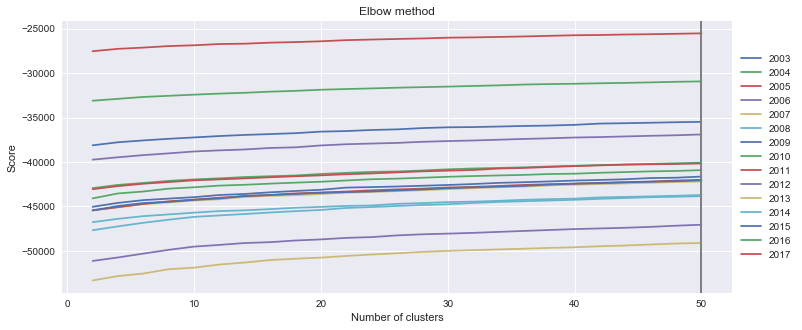

In [25]:
plot('Score', scores, np.argmax)

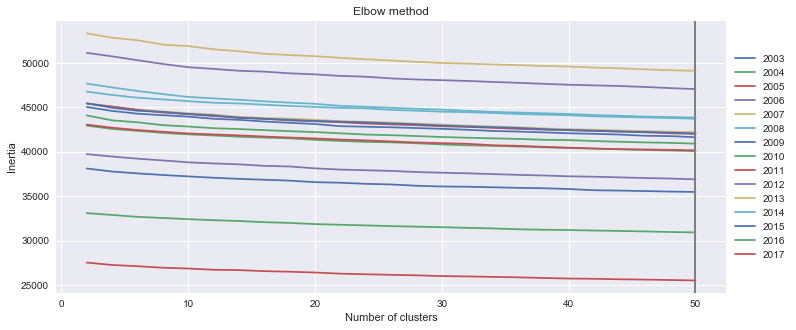

In [26]:
plot('Inertia', inertias, np.argmin)

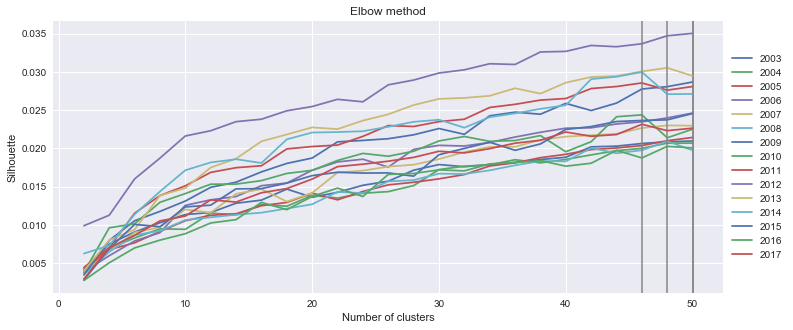

In [27]:
plot('Silhouette', metrics, np.argmax)